# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega_{surf} + R_{diff,R2} \end{equation*}
## **SODA 3.4.2**

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [151]:
client.close()

In [153]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [155]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.7dc5e30174dd489ea12f8720bc859f88 Dashboard: /services/dask-gateway/clusters/staging.7dc5e30174dd489ea12f8720bc859f88/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [160]:
client.close()
cluster.close()

In [115]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from fastjmd95 import jmd95numba
%matplotlib inline
xr.set_options(display_style='text');

In [4]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

In [5]:
path = 'pangeo-tmp/stb2145/SODA/datasets/'

transport = xr.open_zarr(gcsfs.GCSMap(path + 'transport_wg.zarr'))
cells = xr.open_zarr(gcsfs.GCSMap(path + 'cells_wg.zarr'))
surf = xr.open_zarr(gcsfs.GCSMap(path + 'surf_terms.zarr'))
totend = xr.open_zarr(gcsfs.GCSMap(path + 'totend.zarr'))

## <font color='Green'>Fix time for ocean ds</font>
(this is also done in `zarr-SODA-datasets.ipynb`)

In [6]:
#ds.time.data[-1] + 5 to get stop value
data = np.arange(0, 9850, 5)
time_copy = ocean.time.copy(deep=False)
time_coord = time_copy.coords.to_dataset().reset_coords() 
#^separating time coord to be a ds itself so that I can change values of it in next line but keep encoded time info
time_coord_copy = time_coord.time.copy(data=data) 
#^rewriting the coord data for self-created data
time_new_data_coord = time_copy.assign_coords(time=time_coord_copy) 
#^assigning new values for coord to copied time array
time_new = time_new_data_coord.to_dataset(name = 'time_new')
time_new_dec = xr.decode_cf(time_new, decode_coords=True).time_new
ds_new = ocean.drop_vars('time').assign_coords({'time': ('time', time_new_dec.time.values)})
ds_new['time'] = ds_new.time.assign_attrs(ocean.time.attrs)

In [7]:
ds = ds_new

## <font color='Green'>Slice to WG region</font>

In [8]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [9]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [10]:
ds_wg = ds.isel(**lat_range, **lon_range)

In [11]:
import xgcm

grid_wg = xgcm.Grid(ds_wg, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_wg

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [12]:
pref = 2000

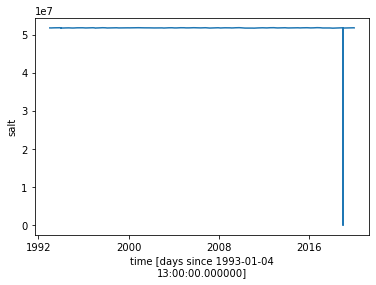

In [19]:
ds_wg.salt.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()

In [13]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

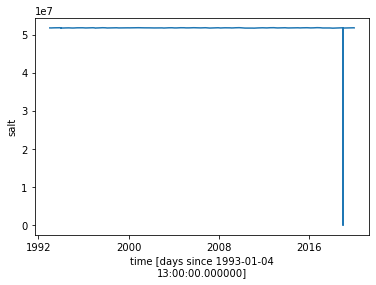

In [57]:
salt_mask.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()
#still shows dip bc of .sum() but mask does work!

In [20]:
salt_mask.dtype

dtype('float32')

In [14]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.7dc5e30174dd489ea12f8720bc859f88 Dashboard: /services/dask-gateway/clusters/staging.7dc5e30174dd489ea12f8720bc859f88/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [15]:
#USE THIS!!
import fastjmd95
sigma2 = fastjmd95.rho(salt_mask, temp_mask, pref)

In [16]:
sigma2

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<transpose, shape=(1970, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00

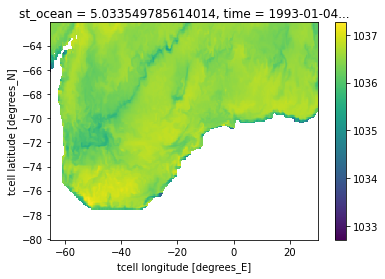

In [22]:
sigma2[0,0].plot()

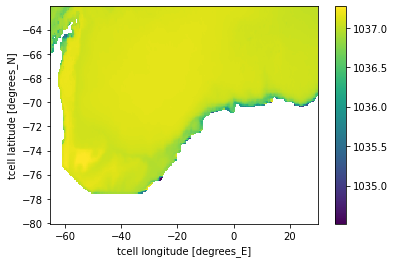

In [24]:
sigma2.mean(dim=['time', 'st_ocean']).plot()

In [25]:
sigma2.nbytes/1e9

50.738532

In [ ]:
sigma2.mean(dim=['time', 'st_ocean']).plot.hist()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

In [18]:
drhodt = fastjmd95.drhodt(salt_mask, temp_mask, pref)
drhods = fastjmd95.drhods(salt_mask, temp_mask, pref)

In [23]:
vol = cells.dx_interp * cells.dy_u * cells.dz

In [135]:
totttend_truth = (totend.totttend * drhodt[1:])# * vol)#.load()

In [136]:
totstend_truth = (totend.totstend * drhods[1:])# * vol)#.load()

In [139]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9
totend_truth = (delta_sigma * vol) / total_time

In [47]:
dt_values = (surf.time.diff('time') / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], 
                  coords={'time': (['time'], surf.time.values[1:])}) #shaves off first time stamp in `surf.time`
surf.coords['dt'] = dt

In [53]:
surf.dt[1:]

<xarray.DataArray 'dt' (time: 1969)>
array([432000., 432000., 432000., ..., 432000., 432000., 432000.],
      dtype=float32)
Coordinates:
    dt       (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05
  * time     (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00

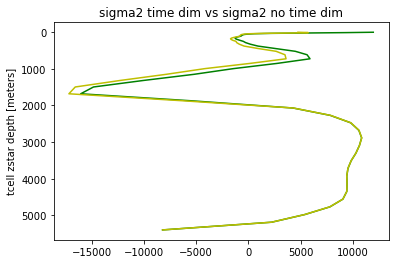

In [57]:
(sigma2.diff(dim='time')*vol/surf.dt[1:]).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim');

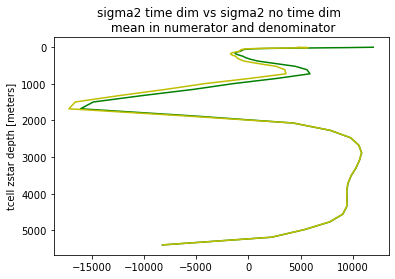

In [67]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, 
                                                                                                               color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim \n mean in numerator and denominator');

In [137]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.7dc5e30174dd489ea12f8720bc859f88 Dashboard: /services/dask-gateway/clusters/staging.7dc5e30174dd489ea12f8720bc859f88/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


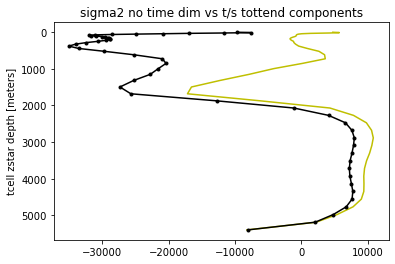

In [140]:
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 no time dim vs t/s tottend components');

In [73]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean'])

<xarray.DataArray (st_ocean: 50)>
dask.array<sum-aggregate, shape=(50,), dtype=float64, chunksize=(50,), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [74]:
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time')

<xarray.DataArray (st_ocean: 50)>
dask.array<mean_agg-aggregate, shape=(50,), dtype=float64, chunksize=(50,), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [76]:
totttend_truth

<xarray.DataArray (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<mul, shape=(1969, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 191), chunktype=numpy.ndarray>
Coordinates:
    dt        (time) float32 dask.array<chunksize=(1969,), meta=np.ndarray>
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [78]:
sigma2.diff(dim='time')

<xarray.DataArray (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<sub, shape=(1969, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00

In [ ]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', 
                                                                                                               yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 time dim vs t/s tottend components');

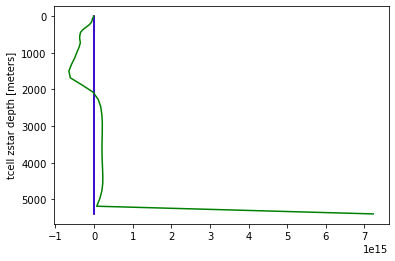

In [97]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', 
                                                                                                               yincrease=False, color='red')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='blue')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green');

In [98]:
totend_truth = ((sigma2.diff(dim='time') * vol) / surf.dt[1:])#.load()

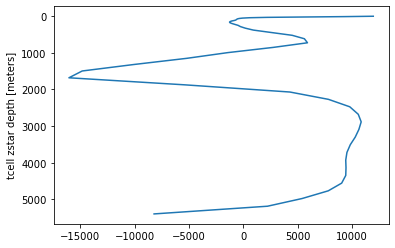

In [88]:
totend_truth.sum(['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

In [99]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.7dc5e30174dd489ea12f8720bc859f88 Dashboard: /services/dask-gateway/clusters/staging.7dc5e30174dd489ea12f8720bc859f88/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


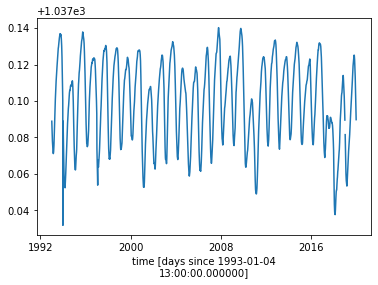

In [101]:
sigma2.mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

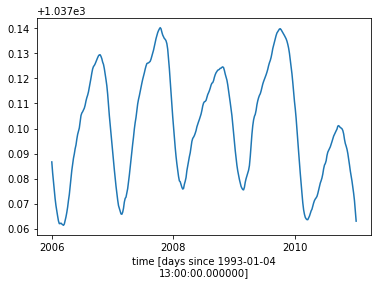

In [105]:
#SOSE time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.sel(time=slice('2006', '2010')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

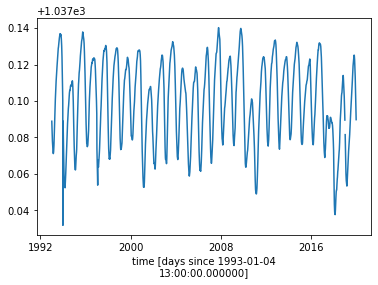

In [106]:
sigma2.sel(time=slice('1980', '2019')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

In [107]:
sigma2.min().values

array(1032.01930673)

In [108]:
sigma2.max().values

array(1039.03267855)

In [142]:
# define bins (ECCO & SOSE bin size 1000)
delta_sigma = 0.01
sigma_bins = np.arange(1032.0, 1039.0, delta_sigma)

In [110]:
sigma_bins.size

700

In [111]:
sigma2.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00

In [112]:
vol.coords

Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [143]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.7dc5e30174dd489ea12f8720bc859f88 Dashboard: /services/dask-gateway/clusters/staging.7dc5e30174dd489ea12f8720bc859f88/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [146]:
totend.totttend

<xarray.DataArray 'totttend' (time: 1969, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<xarray-totttend, shape=(1969, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
    dt        (time) float32 dask.array<chunksize=(1969,), meta=np.ndarray>
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [147]:
sigma2

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<transpose, shape=(1970, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00

In [158]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.7dc5e30174dd489ea12f8720bc859f88 Dashboard: /services/dask-gateway/clusters/staging.7dc5e30174dd489ea12f8720bc859f88/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [ ]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol.fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']).load()

In [ ]:
sigma_dist

In [ ]:
sigma_dist.where(mask).plot(x='time', figsize=(12, 6), cmap='magma')
#plt.ylim(1036.9, 1037.3)

In [ ]:
sigma_dist.where(mask).plot(x='time', figsize=(12, 6), vmax=2.5e15, cmap='magma')
plt.ylim(1036.9, 1037.3)

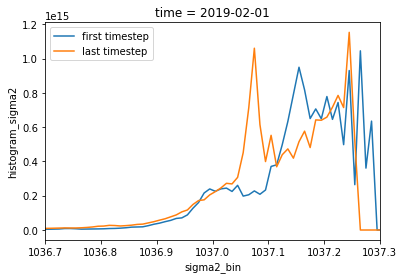

In [38]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.7, 1037.3);

(1037.5, 1036.4)

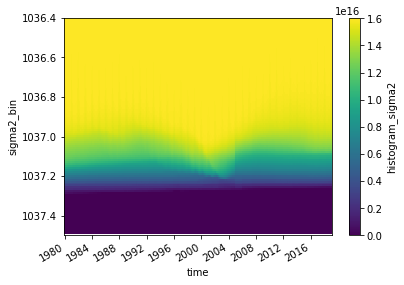

In [27]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.where(mask).transpose().plot()
plt.ylim(1037.5, 1036.4)

In [28]:
V

<xarray.DataArray 'histogram_sigma2' (time: 470, sigma2_bin: 999)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16]])
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

(1037.5, 1036.5)

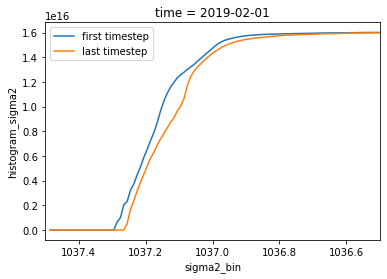

In [29]:
#waters with densities up to 1037.0 became lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.5, 1036.5)

In [30]:
delta_V = V.diff(dim='time')

In [31]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

In [32]:
coords.dt[1:-1]

<xarray.DataArray 'dt' (time: 469)>
dask.array<getitem, shape=(469,), dtype=float32, chunksize=(469,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

## $\frac{\partial \mathcal{V}}{\partial t}$

In [33]:
dVdt = delta_V / coords.dt[1:-1]

In [34]:
dVdt

<xarray.DataArray (time: 469, sigma2_bin: 999)>
dask.array<true_divide, shape=(469, 999), dtype=float64, chunksize=(469, 999), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

(1035.5, 1037.3)

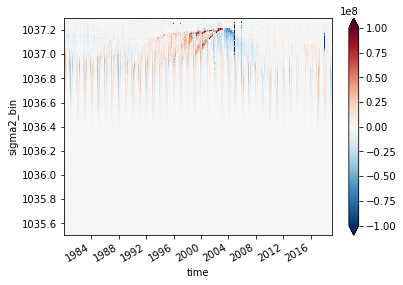

In [35]:
dVdt.where(mask).plot(x='time', vmax=1e8)
plt.ylim(1035.5, 1037.3)

(1035.5, 1037.3)

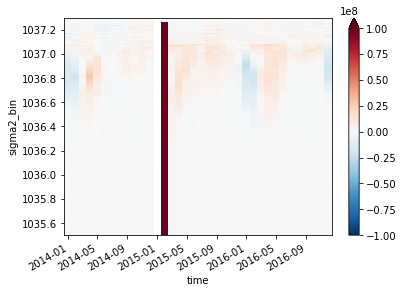

In [88]:
dVdt.where(mask).sel(time=slice('2014', '2016')).plot(x='time', vmax=1e8)
plt.ylim(1035.5, 1037.3)

## $\Omega_{total}$

In [36]:
totend_truth.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

In [37]:
sigma2[1:].coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

In [38]:
omega_total = - histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                          weights=totend_truth.fillna(0.),
                          dim=['lat', 'lon', 'level']) / (- delta_sigma)

In [39]:
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [31]:
dVdt

<xarray.DataArray (time: 469, sigma2_bin: 999)>
dask.array<true_divide, shape=(469, 999), dtype=float64, chunksize=(469, 999), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

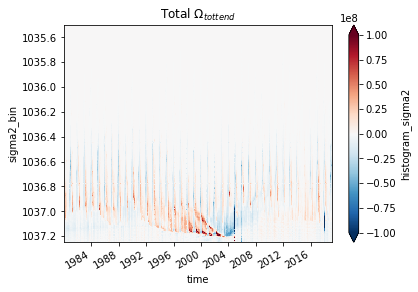

In [40]:
omega_total.plot(x='time', vmax=1e8)
plt.ylim(ymin=1037.25, ymax=1035.5)
plt.title(r'Total $\Omega_{tottend}$');

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of sigma layers) </font>